Epoch[1/25], G Loss: -0.0704, D Loss: -0.6479


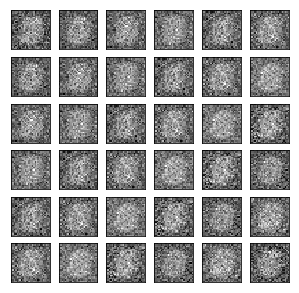

Epoch[2/25], G Loss: -0.2993, D Loss: -0.2852


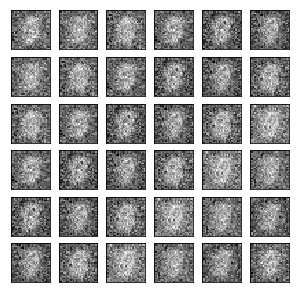

Epoch[3/25], G Loss: -0.0652, D Loss: -0.2206


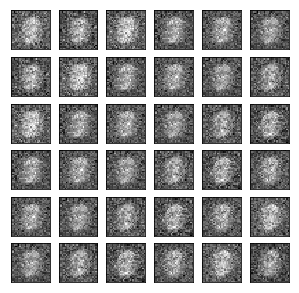

Epoch[4/25], G Loss: -0.0371, D Loss: -0.1285


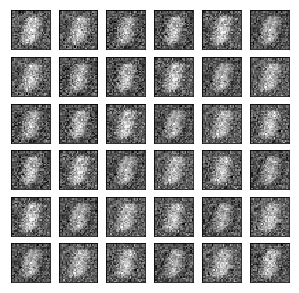

Epoch[5/25], G Loss: -0.0406, D Loss: -0.2219


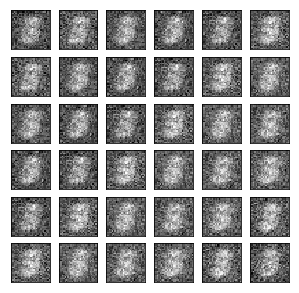

Epoch[6/25], G Loss: -0.0319, D Loss: -0.2255


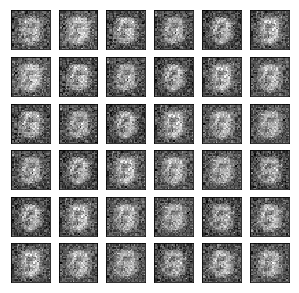

Epoch[7/25], G Loss: -0.0114, D Loss: -0.1204


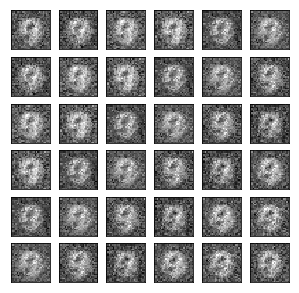

Epoch[8/25], G Loss: -0.0158, D Loss: -0.3086


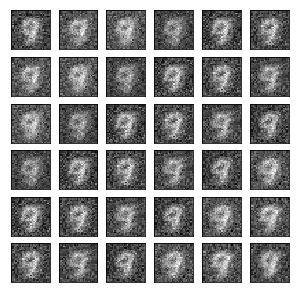

Epoch[9/25], G Loss: -0.0212, D Loss: -0.3241


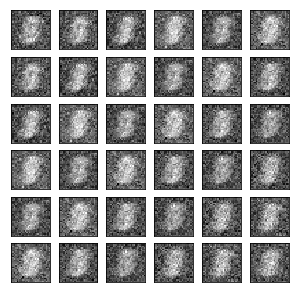

Epoch[10/25], G Loss: -0.0144, D Loss: -0.1659


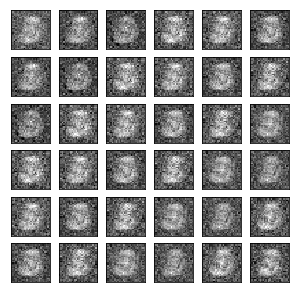

Epoch[11/25], G Loss: -0.0188, D Loss: -0.2335


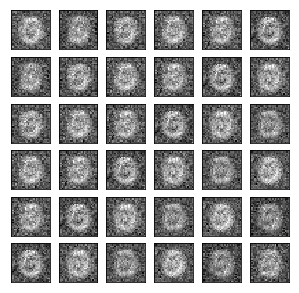

Epoch[12/25], G Loss: -0.0257, D Loss: -0.3233


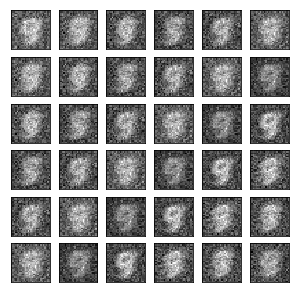

Epoch[13/25], G Loss: -0.0188, D Loss: -0.1523


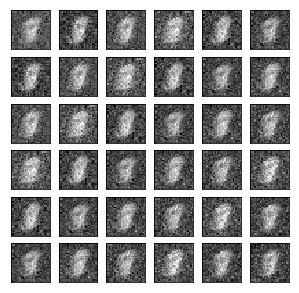

Epoch[14/25], G Loss: -0.0185, D Loss: -0.1779


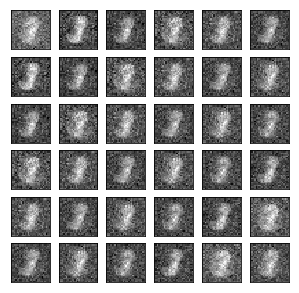

Epoch[15/25], G Loss: -0.0319, D Loss: -0.3162


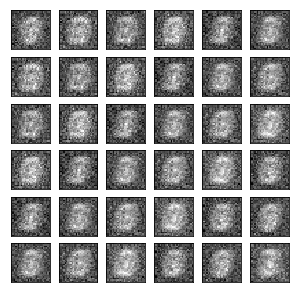

Epoch[16/25], G Loss: -0.0282, D Loss: -0.1342


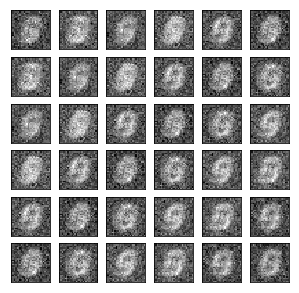

Epoch[17/25], G Loss: -0.0319, D Loss: -0.2263


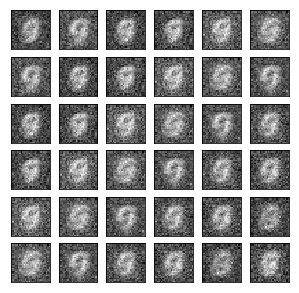

Epoch[18/25], G Loss: -0.0295, D Loss: -0.2155


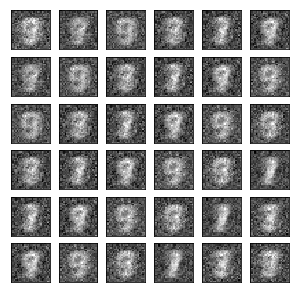

Epoch[19/25], G Loss: -0.0346, D Loss: -0.2009


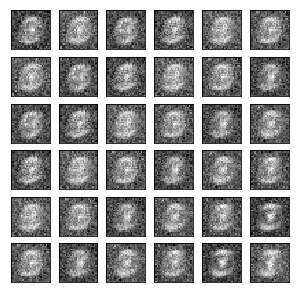

Epoch[20/25], G Loss: -0.0317, D Loss: -0.2004


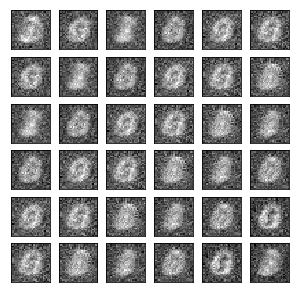

Epoch[21/25], G Loss: -0.0367, D Loss: -0.1985


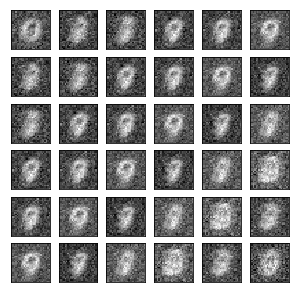

Epoch[22/25], G Loss: -0.0253, D Loss: -0.2048


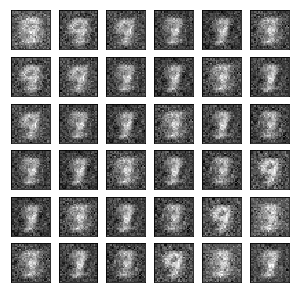

Epoch[23/25], G Loss: -0.0146, D Loss: -0.0667


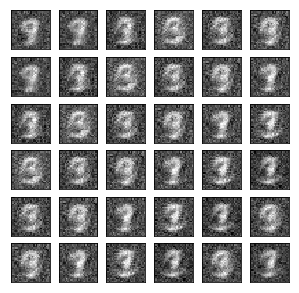

Epoch[24/25], G Loss: -0.0270, D Loss: -0.2256


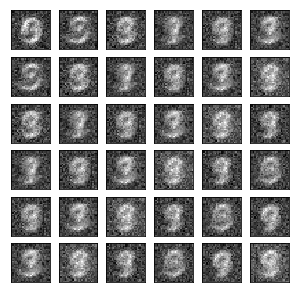

Epoch[25/25], G Loss: -0.0196, D Loss: -0.2567


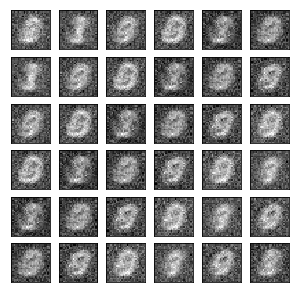

In [1]:
""" (WGAN)
Wasserstein GAN as laid out in original paper.

https://arxiv.org/abs/1701.07875

The output of WGAN's G is unbounded unless passed through an activation function. In this implementation,
we do not include an activation function although in the case of binary MNIST, it may be useful to pass
the output through a sigmoid activation for improved visualizations.

WGAN utilizes the Wasserstein distance to produce a value function whichhas better theoretical properties 
than the vanilla GAN. In particular, the authors prove that there exist distributions for which Jenson-Shannon,
Kullback-Leibler, Reverse Kullback Leibler, and Total Variaton distance metrics where Wasserstein does. Furthermore,
the Wasserstein distance has guarantees of continuity and and differentiability in neural network settings where
the previously mentioned distributions may not. Lastly, they show that that every distribution that converges under 
KL, reverse-KL, TV, and JS divergences also converges under the Wasserstein divergence and that a small Wasserstein
distance corresponds to a small difference in distributions. The downside is that Wasserstein distance cannot be
tractably computed directly. But if we make sure the discriminator (aka Critic because it is not actually classifying) 
lies in the space of 1-Lipschitz functions, we can use that to approximate it instead. We crudely enforce this 
via a weight clamping parameter C.

Note that this implementation uses RMSprop optimizer instead of Adam as per the paper.
"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()


class Generator(nn.Module):
    """ Generator. Input is noise, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = self.generate(activated)
        return generation


class Discriminator(nn.Module):
    """ Critic (not trained to classify). Input is an image (real or generated), 
    output is the approximate Wasserstein Distance between z~P(G(z)) and real.
    """
    def __init__(self, image_size, hidden_dim, output_dim):
        super().__init__()
        
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.relu(self.discriminate(activated))
        return discrimination


class WGAN(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim, output_dim=1):
        super().__init__()
        
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim


class Trainer:
    """ Object to hold data iterators, train a GAN variant 
    """
    def __init__(self, model, train_iter, val_iter, test_iter):
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.Glosses = []
        self.Dlosses = []

    def train(self, num_epochs, G_lr=5e-5, D_lr=5e-5, D_steps=5, clip=0.01):
        """ Train a Wasserstein GAN
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 5e-5)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 5e-5)
            D_steps: int, training step ratio for how often to train D compared to G (default 5)
            clip: float, bound for parameters [-c, c] to crudely ensure K-Lipschitz (default 0.01, (range [-0.01, 0.01]))
        """
        # Initialize optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in self.model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in self.model.D.parameters() if p.requires_grad], lr=D_lr)
    
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            self.model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                for _ in range(D_steps): 

                    # Reshape images
                    images = self.process_batch(self.train_iter)

                    # TRAINING D: Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator to approximate the Wasserstein distance between real, generated
                    # distributions
                    D_loss = self.train_D(images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss.item())
                    
                    # Clamp weights as per original paper (this is a crude way of ensuring K-Lipschitz)
                    self.clip_D_weights(clip)
                                                        
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Train the generator to (roughly) minimize the approximated Wasserstein distance
                G_loss = self.train_G(images)
                
                # Log results, update parameters
                G_losses.append(G_loss.item())
                G_loss.backward()
                G_optimizer.step()
            
            # Save progress
            self.Glosses.extend(G_losses)
            self.Dlosses.extend(D_losses)
                            
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses))) 
            
            # Visualize generator progress
            self.generate_images(epoch)
            plt.show()
        
    def train_D(self, images):
        """ Run 1 step of training for discriminator

        Input:
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: wasserstein loss for discriminator, -E[D(x)] + E[D(G(z))]
        """   
        
        # Sample from the generator
        noise = self.compute_noise(images.shape[0], self.model.z_dim)
        G_output = self.model.G(noise)
        
        # Score real, generated images
        DX_score = self.model.D(images) # D(x), "real"
        DG_score = self.model.D(G_output) # D(G(x')), "fake"
        
        # Compute WGAN loss for D
        D_loss = -1 * (torch.mean(DX_score)) + torch.mean(DG_score)
        
        return D_loss
    
    def train_G(self, images):
        """ Run 1 step of training for generator
        
        Input:
            images: batch of images (reshaped to [batch_size, -1])
        Output:
            G_loss: wasserstein loss for generator, -E[D(G(z))]
        """   
        # Get noise, classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], self.model.z_dim) # z
        G_output = self.model.G(noise) # G(z)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # Compute WGAN loss for G
        G_loss = -1 * (torch.mean(DG_score))
        
        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_cuda(torch.randn(batch_size, z_dim))
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_cuda(images.view(images.shape[0], -1))
        return images
    
    def clip_D_weights(self, clip):
        for parameter in self.model.D.parameters():
            parameter.data.clamp_(-clip, clip)
    
    def generate_images(self, epoch, num_outputs=36, save=True):
        """ Visualize progress of generator learning """
        # Turn off any regularization
        self.model.eval()
        
        # Sample noise vector
        noise = self.compute_noise(num_outputs, self.model.z_dim)
        
        # Transform noise to image
        images = self.model.G(noise)
        
        # Reshape to proper image size
        images = images.view(images.shape[0], 28, 28)
        
        # Plot
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        # Save images if desired
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), 
                                         outname + 'reconst_%d.png'
                                         %(epoch), nrow = 5)
    
    def viz_loss(self):
        """ Visualize loss for the generator, discriminator """
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        plt.plot(self.Dlosses, 'r')
        plt.plot(self.Glosses, 'g')
        
        plt.legend(['Discriminator', 'Generator'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


model = WGAN(image_size=784, 
              hidden_dim=256, 
              z_dim=128)

trainer = Trainer(model=model, 
                  train_iter=train_iter, 
                  val_iter=val_iter, 
                  test_iter=test_iter)

trainer.train(num_epochs=100,
              G_lr=5e-5,
              D_lr=5e-5,
              D_steps=5,
              clip=0.01)